# Section 1.4: Executing and Analyzing Circuits

## Running and analyzing quantum circuits with cirq.Simulator

In this section, you'll learn how to execute quantum circuits and extract meaningful information from quantum states and measurements. We'll explore the difference between ideal simulation and measurement-based results, calculate expectation values, and visualize quantum states.

## Learning Objectives

By the end of this section, you will be able to:

- Understand cirq.Simulator for ideal (noiseless) quantum simulation
- Distinguish between `simulate()` (full state vector) and `run()` (measurement outcomes)
- Create and measure quantum states including Bell states and entangled states
- Calculate expectation values of quantum observables for variational algorithms
- Analyze and visualize measurement statistics and quantum state amplitudes
- Know when to use each execution method for different use cases

In [52]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## 1. Simulator Basics

cirq.Simulator performs ideal (noiseless) simulation of quantum circuits. It can execute circuits and return quantum state information.

In [53]:
print("The cirq.Simulator performs ideal (noiseless) simulation:")
simulator = cirq.Simulator()
print(f"  Simulator type: {type(simulator)}")
print(f"  Simulator: {simulator}")

print("\nSimulator executes circuits and returns quantum state information")

The cirq.Simulator performs ideal (noiseless) simulation:
  Simulator type: <class 'cirq.sim.sparse_simulator.Simulator'>
  Simulator: <cirq.sim.sparse_simulator.Simulator object at 0x133e8d890>

Simulator executes circuits and returns quantum state information


## 2. `run()` vs `simulate()` Methods

These are the two main ways to execute circuits in Cirq. Understanding when to use each is critical for quantum programming.

### 2.1 `simulate()` - Access the Full Quantum State

The `simulate()` method returns the **complete quantum state vector**. This gives you exact amplitudes and probabilities for every basis state—information that's impossible to extract from real quantum hardware in a single experiment!

In [54]:
q = cirq.LineQubit(0)
simulator = cirq.Simulator()

print("simulate() - Returns the complete quantum state vector")
print("This is impossible on real quantum hardware!\n")

circuit = cirq.Circuit(cirq.H(q))
print(f"Circuit:")
print(circuit)

result = simulator.simulate(circuit)
print(f"\nFinal state vector:")
print(f"  {result.final_state_vector}")
print(f"\nInterpretation:")
print(f"  |0⟩ amplitude: {result.final_state_vector[0]:.6f}")
print(f"  |1⟩ amplitude: {result.final_state_vector[1]:.6f}")
print(f"  Probabilities: P(|0⟩)={abs(result.final_state_vector[0])**2:.3f}, "
      f"P(|1⟩)={abs(result.final_state_vector[1])**2:.3f}")

simulate() - Returns the complete quantum state vector
This is impossible on real quantum hardware!

Circuit:
0: ───H───

Final state vector:
  [0.70710677+0.j 0.70710677+0.j]

Interpretation:
  |0⟩ amplitude: 0.707107+0.000000j
  |1⟩ amplitude: 0.707107+0.000000j
  Probabilities: P(|0⟩)=0.500, P(|1⟩)=0.500


### 2.2 `run()` - Mimics Real Quantum Computers

The `run()` method returns only **classical measurement outcomes** (bits). This is what happens on real quantum hardware: you measure and get 0 or 1, nothing more. You can never access the full state vector.

In [55]:
print("run() - Mimics real quantum computers")
print("Returns only classical measurement outcomes\n")

circuit_with_measurement = cirq.Circuit(
    cirq.H(q),
    cirq.measure(q, key='result')
)

print(f"Circuit with measurement:")
print(circuit_with_measurement)

result = simulator.run(circuit_with_measurement, repetitions=10)
print(f"\nMeasurement results (10 shots):")
print(f"  {result.measurements['result'].flatten()}")
print(f"\nNote: No state vector is accessible with run()")

run() - Mimics real quantum computers
Returns only classical measurement outcomes

Circuit with measurement:
0: ───H───M('result')───

Measurement results (10 shots):
  [0 1 1 1 1 0 0 0 0 1]

Note: No state vector is accessible with run()


## 3. Bell State Creation and Measurement

Bell states are maximally entangled two-qubit states. They're a cornerstone of quantum information theory and demonstrate the quantum correlations that have no classical analog.

### 3.1 Creating a Bell State

We create the Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2 using a Hadamard gate on the first qubit and a CNOT gate between the qubits.

In [56]:
print("Bell states are maximally entangled two-qubit states.")
print("Creating |Φ⁺⟩ = (|00⟩ + |11⟩)/√2\n")

q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1)
)

print(f"Bell state circuit:")
print(circuit)

Bell states are maximally entangled two-qubit states.
Creating |Φ⁺⟩ = (|00⟩ + |11⟩)/√2

Bell state circuit:
0: ───H───@───
          │
1: ───────X───


### 3.2 State Vector Analysis

Let's use `simulate()` to examine the exact quantum state. We should see only |00⟩ and |11⟩ with equal amplitudes.

In [57]:
print("--- State Vector Analysis ---\n")

simulator = cirq.Simulator()
result = simulator.simulate(circuit)

print(f"Final state vector:")
for i, amplitude in enumerate(result.final_state_vector):
    basis_state = format(i, '02b')
    print(f"  |{basis_state}⟩: {amplitude:.6f}")

print(f"\nExpected: [1/√2, 0, 0, 1/√2] = [0.707, 0, 0, 0.707]")
print(f"This confirms perfect entanglement: only |00⟩ and |11⟩ appear!")

--- State Vector Analysis ---

Final state vector:
  |00⟩: 0.707107+0.000000j
  |01⟩: 0.000000+0.000000j
  |10⟩: 0.000000+0.000000j
  |11⟩: 0.707107+0.000000j

Expected: [1/√2, 0, 0, 1/√2] = [0.707, 0, 0, 0.707]
This confirms perfect entanglement: only |00⟩ and |11⟩ appear!


### 3.3 Measurement Statistics

Now let's use `run()` to see the measurement outcomes. Despite the state being a perfect superposition, the measurement results will show a key property: perfect correlation between the two qubits.

In [58]:
print("--- Measurement Statistics ---\n")

# Add measurement to the circuit
circuit_with_meas = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='result')
)

result = simulator.run(circuit_with_meas, repetitions=1000)
histogram = result.histogram(key='result')

print(f"Measurement outcomes (1000 shots):")
for bitstring, count in sorted(histogram.items()):
    binary = format(bitstring, '02b')
    percentage = 100 * count / 1000
    print(f"  |{binary}⟩: {count:4d} times ({percentage:5.1f}%)")

print(f"\nNotice:")
print(f"  - Only |00⟩ and |11⟩ outcomes appear (never |01⟩ or |10⟩)")
print(f"  - Perfect correlation: q0 and q1 always match")
print(f"  - Roughly 50/50 distribution between |00⟩ and |11⟩")

--- Measurement Statistics ---

Measurement outcomes (1000 shots):
  |00⟩:  473 times ( 47.3%)
  |11⟩:  527 times ( 52.7%)

Notice:
  - Only |00⟩ and |11⟩ outcomes appear (never |01⟩ or |10⟩)
  - Perfect correlation: q0 and q1 always match
  - Roughly 50/50 distribution between |00⟩ and |11⟩


## 4. Expectation Value Calculations

Expectation values ⟨ψ|O|ψ⟩ are crucial for variational quantum algorithms like VQE (Variational Quantum Eigensolver), QAOA, and quantum machine learning. They tell you the average measurement outcome of a quantum observable for a given state.

### 4.1 Z Expectation on |0⟩

In [59]:
q = cirq.LineQubit(0)
simulator = cirq.Simulator()

print("1. Z expectation on |0⟩ state:\n")
circuit = cirq.Circuit(cirq.I(q))  # |0⟩ state

result = simulator.simulate(circuit)
observable = cirq.Z(q).with_qubits(q)
expectation = observable.expectation_from_state_vector(
    result.final_state_vector,
    qubit_map={q: 0}
)

print(f"  ⟨0|Z|0⟩ = {expectation:.6f}")
print(f"  Expected: +1 (eigenvalue of Z for |0⟩)")

1. Z expectation on |0⟩ state:

  ⟨0|Z|0⟩ = 1.000000+0.000000j
  Expected: +1 (eigenvalue of Z for |0⟩)


### 4.2 X Expectation on |+⟩

In [60]:
print("\n2. X expectation on |+⟩ state:\n")
circuit = cirq.Circuit(cirq.H(q))  # |+⟩ state

result = simulator.simulate(circuit)
observable = cirq.X(q).with_qubits(q)
expectation = observable.expectation_from_state_vector(
    result.final_state_vector,
    qubit_map={q: 0}
)

print(f"  ⟨+|X|+⟩ = {expectation:.6f}")
print(f"  Expected: +1 (|+⟩ is +1 eigenstate of X)")


2. X expectation on |+⟩ state:

  ⟨+|X|+⟩ = 1.000000+0.000000j
  Expected: +1 (|+⟩ is +1 eigenstate of X)


### 4.3 Multiple Observables on Superposition

In [61]:
print("\n3. Multiple observables on |+⟩ state:\n")
circuit = cirq.Circuit(cirq.H(q))

result = simulator.simulate(circuit)

observables = {
    'X': cirq.X(q).with_qubits(q),
    'Y': cirq.Y(q).with_qubits(q),
    'Z': cirq.Z(q).with_qubits(q)
}

print(f"  State: |+⟩ = (|0⟩ + |1⟩)/√2")
for name, obs in observables.items():
    exp = obs.expectation_from_state_vector(
        result.final_state_vector,
        qubit_map={q: 0}
    )
    # Hermitian operators (like X, Y, Z) guarantee real expectation values
    # Extract .real to discard numerical noise in imaginary part
    print(f"  ⟨{name}⟩ = {exp.real:.6f}")


3. Multiple observables on |+⟩ state:

  State: |+⟩ = (|0⟩ + |1⟩)/√2
  ⟨X⟩ = 1.000000
  ⟨Y⟩ = 0.000000
  ⟨Z⟩ = -0.000000


### 4.4 Two-Qubit Observable on Bell State

In [62]:
print("\n4. ZZ expectation on Bell state |Φ⁺⟩:\n")
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1)
)

result = simulator.simulate(circuit)
observable = cirq.Z(q0) * cirq.Z(q1)
expectation = observable.expectation_from_state_vector(
    result.final_state_vector,
    qubit_map={q0: 0, q1: 1}
)

print(f"  ⟨Φ⁺|Z₀Z₁|Φ⁺⟩ = {expectation:.3f}")
print(f"  Expected: +1 (Bell state has perfect Z-correlation)")


4. ZZ expectation on Bell state |Φ⁺⟩:

  ⟨Φ⁺|Z₀Z₁|Φ⁺⟩ = 1.000+0.000j
  Expected: +1 (Bell state has perfect Z-correlation)


## 5. When to Use `run()` vs `simulate()`

Knowing when to use each method is critical for effective quantum programming.

### Use `run()` when:

- ✓ Preparing for real hardware experiments
- ✓ Need measurement statistics (histograms, probabilities)
- ✓ Testing sampling-based algorithms (QAOA, quantum ML)
- ✓ Want to mimic actual quantum computer behavior

### Use `simulate()` when:

- ✓ Debugging circuit logic
- ✓ Need exact state vector or amplitudes
- ✓ Calculating expectation values
- ✓ Verifying theoretical predictions
- ✓ Teaching and understanding quantum mechanics

### Key difference:

- `run()`      → Returns classical bits (like real hardware)
- `simulate()` → Returns quantum state (impossible on real hardware)

## 6. Measurement Histogram Visualization

Visualizing measurement distributions helps understand the probability of getting different outcomes.

Generating histograms for:
  1. Single-qubit superposition: H|0⟩
  2. Bell state: (|00⟩ + |11⟩)/√2
  3. GHZ state: (|000⟩ + |111⟩)/√2

  Saved to: measurement_histograms.png


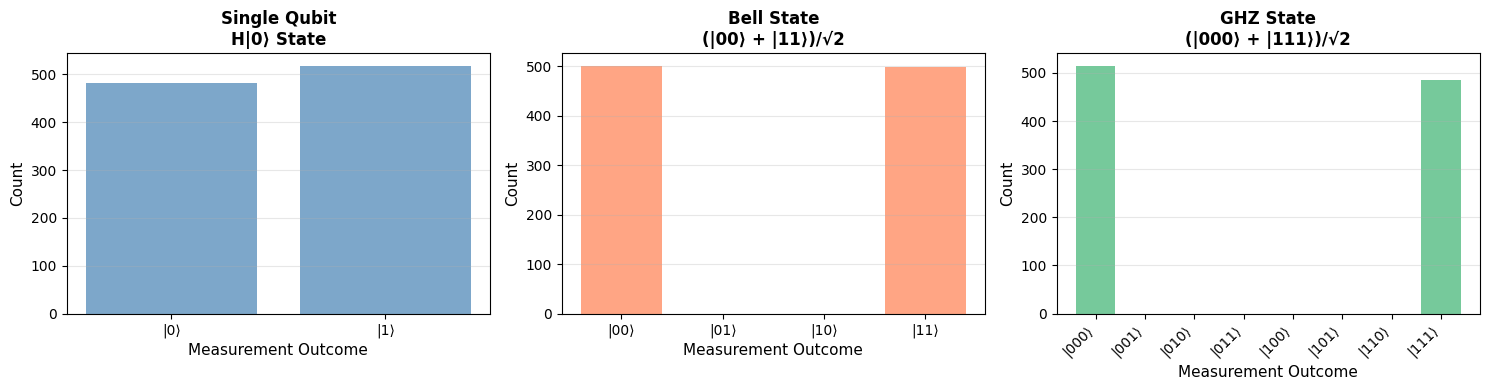

In [63]:
simulator = cirq.Simulator()
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# State 1: Single qubit superposition
print("Generating histograms for:")
print("  1. Single-qubit superposition: H|0⟩")

q = cirq.LineQubit(0)
circuit = cirq.Circuit(
    cirq.H(q),
    cirq.measure(q, key='result')
)

result = simulator.run(circuit, repetitions=1000)
histogram = result.histogram(key='result')

axes[0].bar(histogram.keys(), histogram.values(), color='steelblue', alpha=0.7)
axes[0].set_xlabel('Measurement Outcome', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Single Qubit\nH|0⟩ State', fontsize=12, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['|0⟩', '|1⟩'])
axes[0].grid(axis='y', alpha=0.3)

# State 2: Bell state
print("  2. Bell state: (|00⟩ + |11⟩)/√2")

q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.measure(q0, q1, key='result')
)

result = simulator.run(circuit, repetitions=1000)
histogram = result.histogram(key='result')

labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
counts = [histogram.get(i, 0) for i in range(4)]

axes[1].bar(range(4), counts, color='coral', alpha=0.7)
axes[1].set_xlabel('Measurement Outcome', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Bell State\n(|00⟩ + |11⟩)/√2', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(labels)
axes[1].grid(axis='y', alpha=0.3)

# State 3: GHZ state (three qubits)
print("  3. GHZ state: (|000⟩ + |111⟩)/√2")

q0, q1, q2 = cirq.LineQubit.range(3)
circuit = cirq.Circuit(
    cirq.H(q0),
    cirq.CNOT(q0, q1),
    cirq.CNOT(q0, q2),
    cirq.measure(q0, q1, q2, key='result')
)

result = simulator.run(circuit, repetitions=1000)
histogram = result.histogram(key='result')

labels = [f'|{format(i, "03b")}⟩' for i in range(8)]
counts = [histogram.get(i, 0) for i in range(8)]

axes[2].bar(range(8), counts, color='mediumseagreen', alpha=0.7)
axes[2].set_xlabel('Measurement Outcome', fontsize=11)
axes[2].set_ylabel('Count', fontsize=11)
axes[2].set_title('GHZ State\n(|000⟩ + |111⟩)/√2', fontsize=12, fontweight='bold')
axes[2].set_xticks(range(8))
axes[2].set_xticklabels(labels, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('measurement_histograms.png', dpi=150, bbox_inches='tight')
print("\n  Saved to: measurement_histograms.png")
plt.show()

## 7. State Vector Visualization

Visualizing state vector amplitudes and phases provides intuition about quantum states. Bars are colored by phase to show both magnitude and phase information.

Generating state vector visualizations...

  Saved to: state_vectors.png


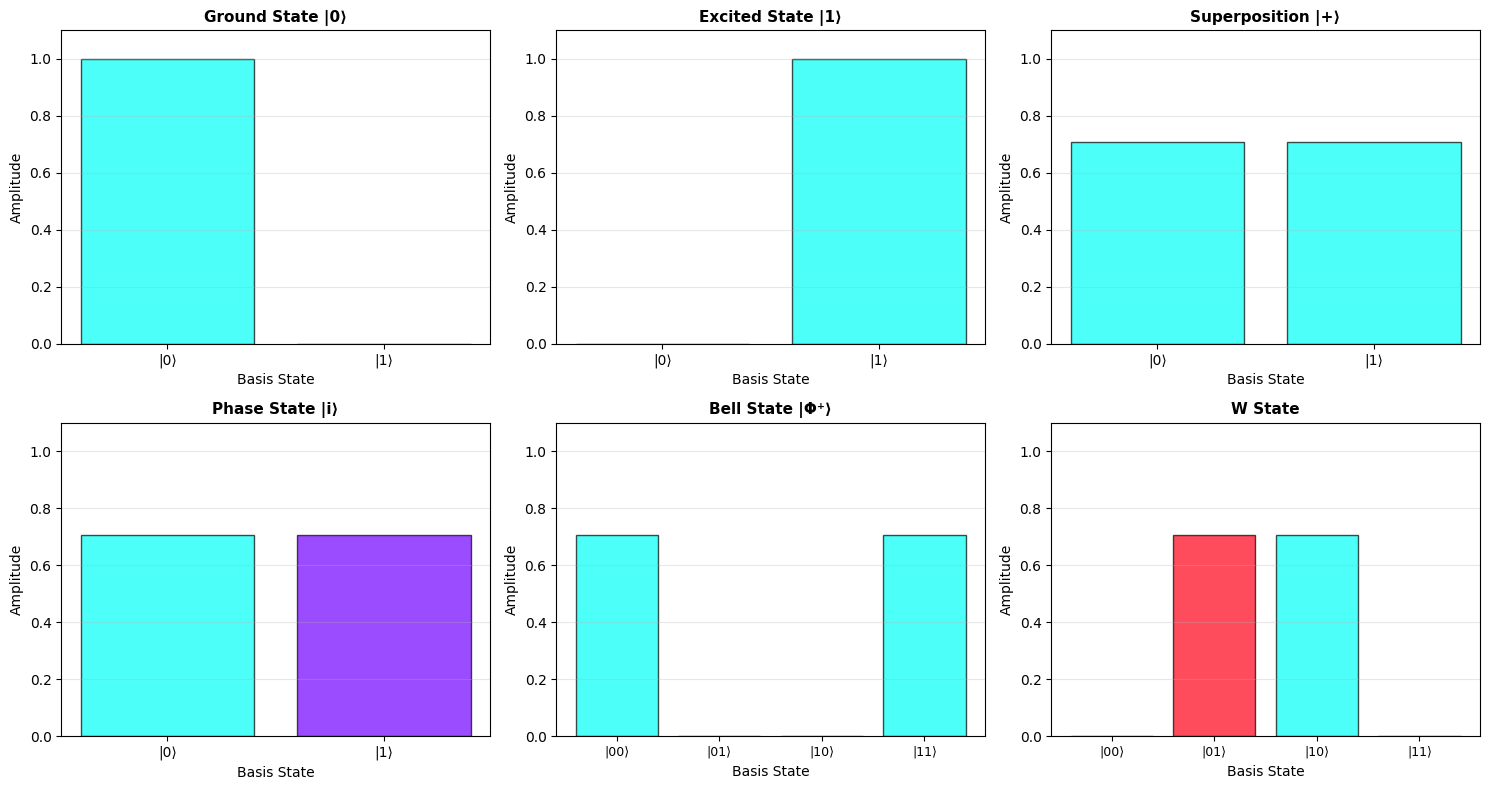

In [64]:
simulator = cirq.Simulator()
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

states = [
    ("Ground State |0⟩", cirq.Circuit(cirq.I(cirq.LineQubit(0)))),
    ("Excited State |1⟩", cirq.Circuit(cirq.X(cirq.LineQubit(0)))),
    ("Superposition |+⟩", cirq.Circuit(cirq.H(cirq.LineQubit(0)))),
    # H then S creates (|0⟩ + i|1⟩)/√2: equal superposition with π/2 phase
    ("Phase State |i⟩", cirq.Circuit([cirq.H(cirq.LineQubit(0)), cirq.S(cirq.LineQubit(0))])),
    # H on q0 then CNOT(q0,q1) creates (|00⟩ + |11⟩)/√2: maximally entangled
    ("Bell State |Φ⁺⟩", cirq.Circuit([cirq.H(cirq.LineQubit(0)), cirq.CNOT(cirq.LineQubit(0), cirq.LineQubit(1))])),
    # W state: symmetric superposition |100⟩ + |010⟩ + |001⟩ (partial entanglement)
    ("W State", cirq.Circuit([cirq.X(cirq.LineQubit(0)), cirq.H(cirq.LineQubit(0)), cirq.CNOT(cirq.LineQubit(0), cirq.LineQubit(1)), cirq.X(cirq.LineQubit(0))]))
]

print("Generating state vector visualizations...\n")

for idx, (name, circuit) in enumerate(states):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector

    # Plot amplitudes
    n_basis_states = len(state_vector)
    indices = np.arange(n_basis_states)
    amplitudes = np.abs(state_vector)
    phases = np.angle(state_vector)

    # Color by phase
    colors = plt.cm.hsv(phases / (2 * np.pi) + 0.5)

    bars = ax.bar(indices, amplitudes, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

    ax.set_xlabel('Basis State', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_title(name, fontsize=11, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)

    # Set x-tick labels
    n_qubits = int(np.log2(n_basis_states))
    if n_qubits == 1:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['|0⟩', '|1⟩'])
    elif n_qubits == 2:
        ax.set_xticks(range(4))
        ax.set_xticklabels(['|00⟩', '|01⟩', '|10⟩', '|11⟩'], fontsize=9)
    else:
        ax.set_xticks(range(n_basis_states))
        ax.set_xticklabels([f'|{format(i, f"0{n_qubits}b")}⟩' for i in range(n_basis_states)],
                         rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.savefig('state_vectors.png', dpi=150, bbox_inches='tight')
print("  Saved to: state_vectors.png")
plt.show()

## Exercises

1. **Bell State Variations**: Modify the Bell state circuit to create the |Ψ⁺⟩ state (with an X gate before the CNOT). Predict and verify the state vector.

2. **Expectation Value Chain**: Create a circuit that prepares |+⟩ state and calculate expectation values of X, Y, and Z. Which one equals zero and why?

3. **Measurement Fidelity**: Run a |0⟩ state 1000 times with `run()`. What percentage of measurements give |0⟩? Is it exactly 100% or close due to simulation?

4. **GHZ State Analysis**: Create a 3-qubit GHZ state and calculate the XXX expectation value. What do you expect?

5. **Hardware Preparation**: Design a circuit that would be useful on real hardware. Why would you use `run()` instead of `simulate()` to test it?

## Key Takeaways

- **cirq.Simulator** performs ideal (noiseless) quantum simulation useful for testing and verification
- **`simulate()` returns the full state vector** - useful for debugging and theoretical verification but impossible on real hardware
- **`run()` returns only measurement outcomes** - mimics real quantum computers and is essential for testing hardware-ready code
- **Expectation values** ⟨ψ|O|ψ⟩ are critical for variational quantum algorithms (VQE, QAOA, quantum ML)
- **Entangled states** like Bell states show quantum correlations with no classical analog
- **Measurement statistics** reveal the probability distributions encoded in quantum states
- Always verify circuits with ideal simulation before testing on real hardware

---

**Next:** [Section 1.5 - Parameterized Circuits](part1_section_1_5_parameters.ipynb) - Learn to create parameterized circuits for variational quantum algorithms